# Load and bin microscopy fluorescent data for HQNO (Inner part of chamber only)

This notebook analyzes HQNO gradient microscopy data by:
1. Loading raw microscopy data and filtering for wild-type (wt) samples
2. Spatially binning the data into a 30x30 grid based on x,y coordinates
3. Focusing on the inner region of chambers (excluding optical edge artifacts)
4. Plotting median GFP intensity profiles across distance for all chambers and replicates
5. Saving the processed data for downstream analysis

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

class HQNOAnalyzer:
    def __init__(self, filepath: str, num_x_bins: int = 30, num_y_bins: int = 30):
        self.filepath = filepath
        self.num_x_bins = num_x_bins
        self.num_y_bins = num_y_bins
        self.raw_df = None
        self.df = None
        self.x_bins = None
        self.y_bins = None

    def load_data(self):
        """Read CSV into raw_df."""
        self.raw_df = pd.read_csv(self.filepath)
        return self

    def filter_wt(self, col: str = "HQNO", wt_value: str = "wt"):
        """Keep only rows where raw_df[col] == wt_value."""
        if self.raw_df is None:
            raise RuntimeError("Call load_data() first.")
        self.df = self.raw_df[self.raw_df[col] == wt_value].copy()
        return self

    def define_binning(self, x_col: str = "x", y_col: str = "y"):
        """Compute bin edges and assign x_bin, y_bin to self.df."""
        if self.df is None:
            raise RuntimeError("Call filter_wt() first.")

        self.x_bins = np.linspace(self.df[x_col].min(), self.df[x_col].max(), self.num_x_bins + 1)
        self.y_bins = np.linspace(self.df[y_col].min(), self.df[y_col].max(), self.num_y_bins + 1)

        self.df['x_bin'] = np.digitize(self.df[x_col], self.x_bins, right=False) - 1
        self.df['y_bin'] = np.digitize(self.df[y_col], self.y_bins, right=False) - 1

        self.df['x_bin'] = self.df['x_bin'].clip(0, self.num_x_bins - 1)
        self.df['y_bin'] = self.df['y_bin'].clip(0, self.num_y_bins - 1)
        return self

    def get_subsets(self):
        """Return wt_all, wt_inner, and wt_outer DataFrames."""
        wt_all = self.df
        outer_bins = list(range(0, 4)) + list(range(self.num_x_bins - 4, self.num_x_bins))
        wt_outer = wt_all[wt_all['x_bin'].isin(outer_bins)]
        wt_inner = wt_all[wt_all['x_bin'].between(4, self.num_x_bins - 5)]
        return {'wt_all': wt_all, 'wt_inner': wt_inner, 'wt_outer': wt_outer}

    def get_replicates(self):
        """Return dict of replicates using the INNER region with per-replicate exclusions."""
        wt_inner = self.get_subsets()['wt_inner']  # <<< switched to inner >>>
        exclusions = {
            'replicate_4': [],
            'replicate_5': [],
            'replicate_7': [],
        }
        reps = {}
        for rep, exclude in exclusions.items():
            df_rep = wt_inner[wt_inner['replicate_name'] == rep]
            if exclude:
                df_rep = df_rep[~df_rep['pos'].isin(exclude)]
            reps[rep] = df_rep
        return reps

    def plot_all_chambers(self):
        """
        Line plot of median intensity for every chamber across all replicates in one figure,
        using a distinct color per replicate and a single legend entry per replicate.
        Uses the INNER region.
        """
        reps = self.get_replicates()
        fig, ax = plt.subplots(figsize=(10, 6))
        cmap = plt.get_cmap('tab10', len(reps))
        rep_colors = {rep: cmap(i) for i, rep in enumerate(reps)}

        for rep, df_rep in reps.items():
            color = rep_colors[rep]
            for _, df_pos in df_rep.groupby('pos'):
                stats = df_pos.groupby('y_bin')['intensity_raw_gfp'].median().reset_index()
                ax.plot(stats['y_bin'], stats['intensity_raw_gfp'], color=color)

        handles = [Line2D([0], [0], color=rep_colors[rep], lw=2) for rep in reps]
        labels = list(reps.keys())
        ax.legend(handles, labels, title='Replicate', bbox_to_anchor=(1.05, 1), loc='upper left')

        ax.set(title='Median Raw gfp Intensity vs Distance for All Chambers; Inner Region',
               xlabel='Distance to PA', ylabel='Median Raw gfp Intensity')
        plt.tight_layout()

    def save_plot_data(self, csv_path: str) -> pd.DataFrame:
        """
        Save median intensity vs y_bin for each replicate and chamber to CSV (INNER region).
        Returns the DataFrame that was saved.
        """
        reps = self.get_replicates()
        records = []
        for rep, df_rep in reps.items():
            for pos, df_pos in df_rep.groupby('pos'):
                stats = df_pos.groupby('y_bin')['intensity_raw_gfp'].median().reset_index()
                for _, row in stats.iterrows():
                    records.append({
                        'replicate': rep,
                        'pos': pos,
                        'y_bin': row['y_bin'],
                        'median_intensity': row['intensity_raw_gfp']
                    })
        df_out = pd.DataFrame.from_records(records)
        df_out.to_csv(csv_path, index=False)
        return df_out

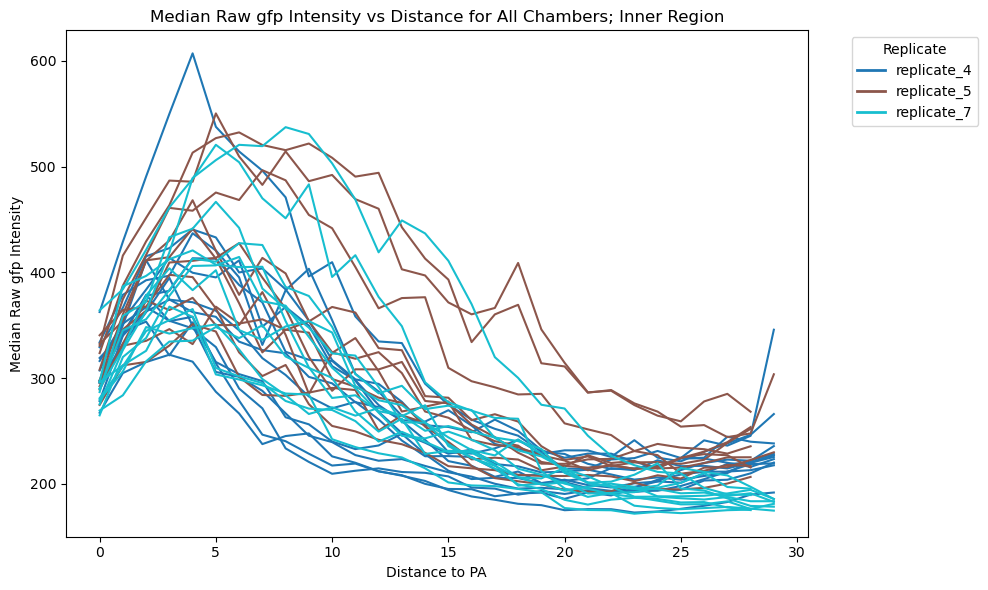

In [ ]:
file_name = '0_HQNO_gfp_gradient_binned_inner'

analyzer = (
    HQNOAnalyzer(
        filepath= Path.cwd().parents[1] / 'datafiles' / 'hqno_gradient_microscopy.csv',
        num_x_bins=30,
        num_y_bins=30
    )
    .load_data()
    .filter_wt()
    .define_binning()
)
analyzer.plot_all_chambers()
df_data = analyzer.save_plot_data(Path.cwd() / 'data' / (file_name + '.csv')) # old name: '3A_HQNO_gfp_gradient_visualization
plt.savefig(Path.cwd() / 'figures' / (file_name + '.pdf'), dpi=300, transparent=True)